Q: What does "pay more tips" mean? How much is "more"? How you compare is to "less" tips? 

A: pay more tips is a relative term. It can be expressed as Tips paid per total amount or per distance or per duration.
More and less is also very relative. If there is a significant difference in values in the first quartile relative
to median quartile then we could say that tip was paid less. Similarly third quartile of sample points with tip_per_total
would contain high tips.

Q: What are some extreme cases.
A: Some extreme cases are when the trip duration is 24 hours or when total amount paid is negative
    
Q: Analysis per weekday, hour and number of passengers
A: Aggregating tip_per_total against weekday or hour does not have significant difference
   Regarding passgenger count. I saw a significant drop when the passenger count was 9
    
Things to do in order to solve the problem which areas of NY pay the highest tips
1. Merge Community District Name with the above Data frame
    - Call APIs to for every row in Dataframe to get District Name. Can be very time consuming since there are 12M rows
    - Get a shape which contains District names and merge with Dataframe.
2. Aggregate info per Community District and check out if the mean values of some districts are significantly greater than others

In [1]:
import numpy as np
import pandas as pd
import matplotlib  
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
import fiona
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
import json
import datetime
import seaborn
%matplotlib inline 

In [2]:
nyc_data = pd.read_csv('yellow_tripdata_2015-06.csv', nrows=1000000, parse_dates=[1,2])

In [3]:
nyc_data.describe()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1.523680,1.689017,1.598918e+01,-72.865534,40.140212,1.039960,-72.889442,40.153767,1.375050,13.213712,0.411108,0.497761,1.758864,0.297774,0.299720,16.479824
std,0.499439,1.331861,8.707910e+03,8.984223,4.948283,0.565749,8.918407,4.898203,0.498638,11.040034,0.378762,0.035974,2.740201,1.470553,0.012264,13.494211
min,1.000000,0.000000,0.000000e+00,-86.031525,0.000000,1.000000,-736.583313,0.000000,1.000000,-171.000000,-1.000000,-0.500000,-80.000000,-5.540000,-0.300000,-171.800000
25%,1.000000,1.000000,1.000000e+00,-73.991898,40.735325,1.000000,-73.991219,40.733837,1.000000,7.000000,0.000000,0.500000,0.000000,0.000000,0.300000,8.800000
50%,2.000000,1.000000,1.700000e+00,-73.981522,40.752911,1.000000,-73.979713,40.753311,1.000000,10.000000,0.500000,0.500000,1.200000,0.000000,0.300000,12.350000
75%,2.000000,2.000000,3.190000e+00,-73.966278,40.768112,1.000000,-73.962219,40.769600,2.000000,15.000000,0.500000,0.500000,2.450000,0.000000,0.300000,18.360000
max,2.000000,9.000000,8.000000e+06,125.535568,59.032299,99.000000,125.535568,56.766262,5.000000,670.060000,20.200000,1.300000,980.910000,511.160000,0.300000,990.710000


#### Data Columns

In [4]:
nyc_data.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
pickup_longitude                float64
pickup_latitude                 float64
RateCodeID                        int64
store_and_fwd_flag               object
dropoff_longitude               float64
dropoff_latitude                float64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
dtype: object

In [5]:
nyc_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-06-02 11:19:29,2015-06-02 11:47:52,1,1.63,-73.954430,40.764141,1,N,-73.974754,40.754093,2,17.0,0.0,0.5,0.00,0.0,0.3,17.80
1,2,2015-06-02 11:19:30,2015-06-02 11:27:56,1,0.46,-73.971443,40.758942,1,N,-73.978539,40.761909,1,6.5,0.0,0.5,1.00,0.0,0.3,8.30
2,2,2015-06-02 11:19:31,2015-06-02 11:30:30,1,0.87,-73.978111,40.738434,1,N,-73.990273,40.745438,1,8.0,0.0,0.5,2.20,0.0,0.3,11.00
3,2,2015-06-02 11:19:31,2015-06-02 11:39:02,1,2.13,-73.945892,40.773529,1,N,-73.971527,40.760330,1,13.5,0.0,0.5,2.86,0.0,0.3,17.16
4,1,2015-06-02 11:19:32,2015-06-02 11:32:49,1,1.40,-73.979088,40.776772,1,N,-73.982162,40.758999,2,9.5,0.0,0.5,0.00,0.0,0.3,10.30


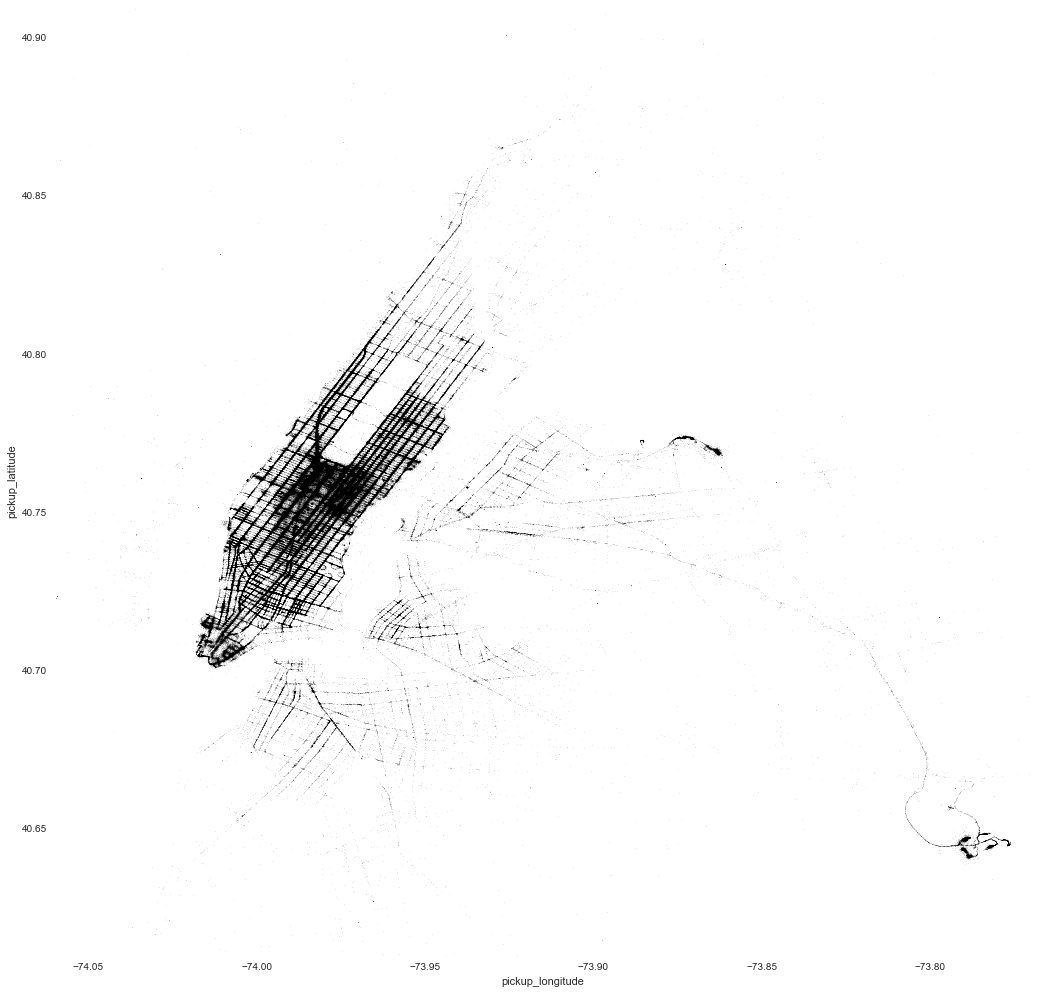

In [7]:
# Fancy data plotting. Uncomment the following

plt.style.use = 'default' #Better Styling  
new_style = {'grid': False} #Remove grid  
matplotlib.rc('axes', **new_style)  
from matplotlib import rcParams  
rcParams['figure.figsize'] = (17.5, 17) #Size of figure  
rcParams['figure.dpi'] = 250

# P.set_axis_bgcolor('black') #Background Color

P=nyc_data.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',color='black',xlim=(-74.06,-73.77),ylim=(40.61, 40.91),s=.02,alpha=.6)
P.set_axis_bgcolor('white')

In [8]:
# Drop column with payment type 2 since all rows with this row have 0 tip amount
nyc_data = nyc_data.drop(nyc_data[nyc_data.payment_type == 2].index)

# Create additional features to do some EDA
nyc_data['tip_per_total'] = nyc_data['tip_amount'] / nyc_data['total_amount']
nyc_data['tip_per_distance'] = nyc_data['tip_amount'] / nyc_data['trip_distance']
nyc_data['trip_duration'] = nyc_data['tpep_dropoff_datetime'] - nyc_data['tpep_pickup_datetime']
nyc_data['trip_seconds'] = nyc_data.trip_duration.apply(lambda x: x.seconds)
nyc_data['tip_per_duration'] = nyc_data['tip_amount'] / nyc_data['trip_seconds']
nyc_data['weekday'] = nyc_data['tpep_pickup_datetime'].apply(lambda x: x.strftime("%A"))
nyc_data['pickup_hour'] = nyc_data['tpep_pickup_datetime'].apply(lambda x: x.hour)

# Drop Rows where some columns are 0 cause they will skew the results
nyc_data = nyc_data.drop(nyc_data[nyc_data.tip_per_total == 0.0].index)
nyc_data = nyc_data.drop(nyc_data[nyc_data.trip_seconds == 0.0].index)
nyc_data = nyc_data.drop(nyc_data[nyc_data.trip_distance == 0.0].index)

In [9]:
weekday_hour_group = nyc_data.groupby(['weekday', 'pickup_hour']).mean()

In [10]:
nyc_data.shape[0]

606660

##### EDA plots

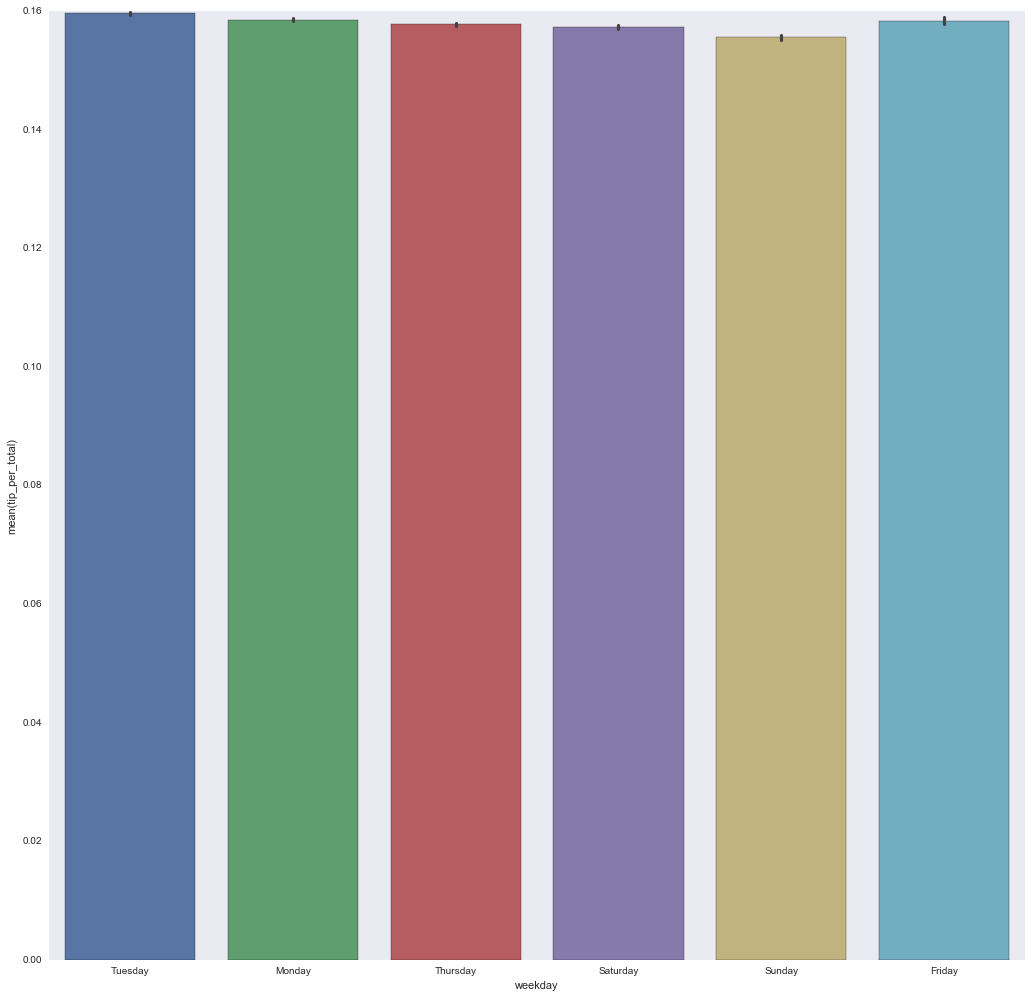

In [11]:
seaborn.barplot(x=nyc_data.weekday, y=nyc_data.tip_per_total)

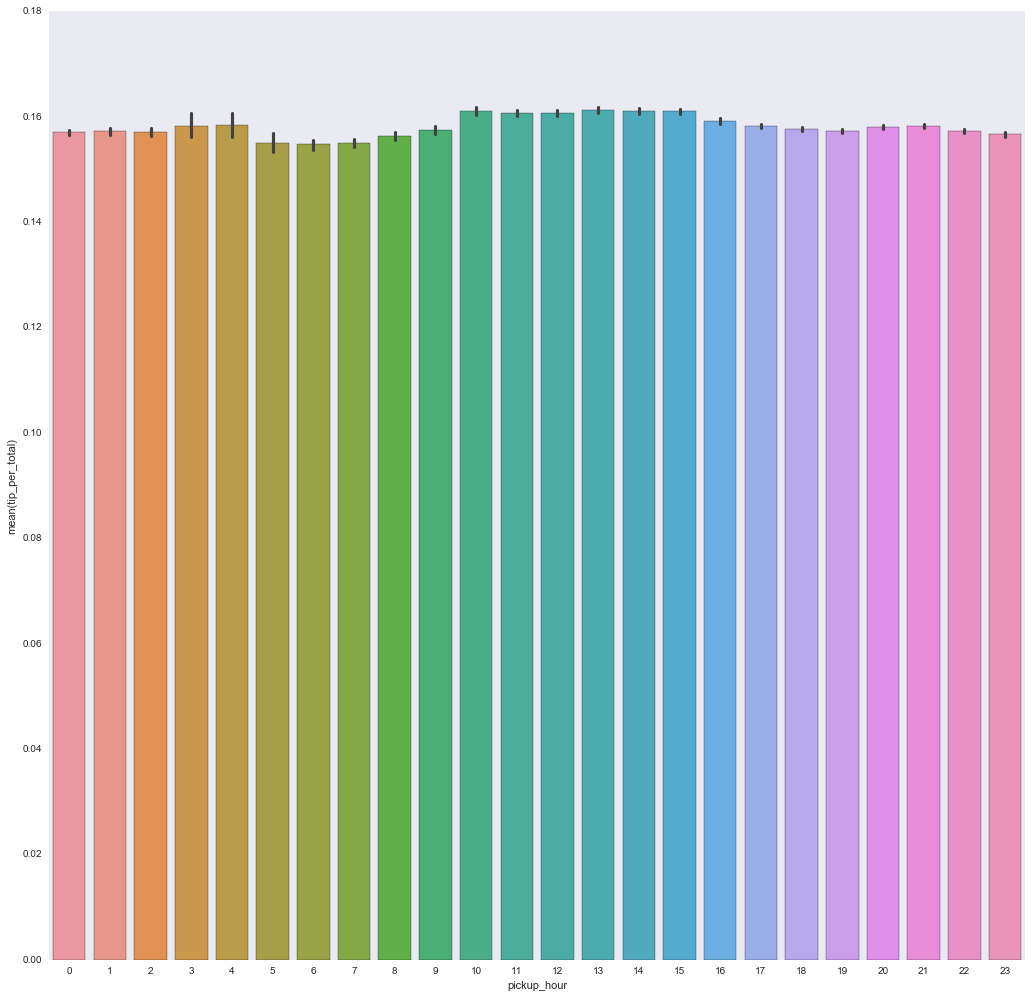

In [12]:
seaborn.barplot(x=nyc_data.pickup_hour, y=nyc_data.tip_per_total)

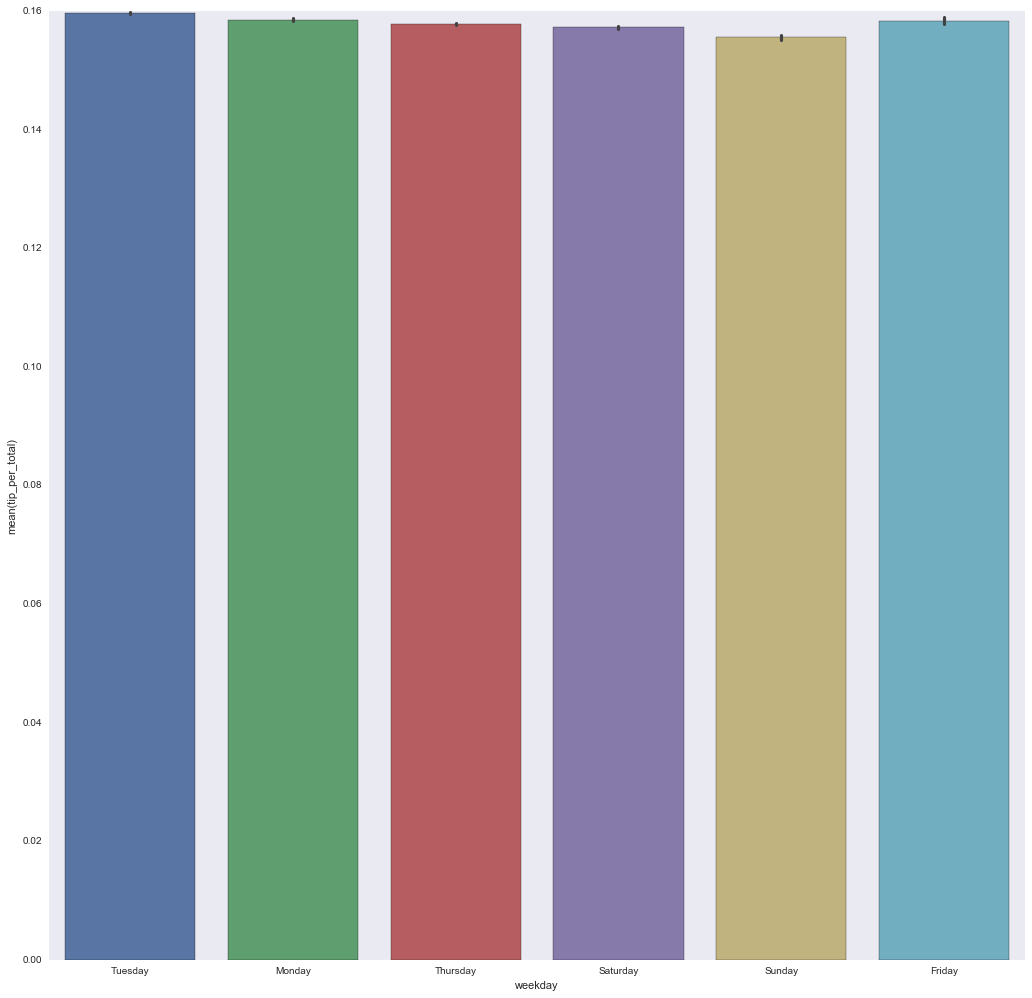

In [13]:
seaborn.barplot(x=nyc_data.weekday, y=nyc_data.tip_per_total)

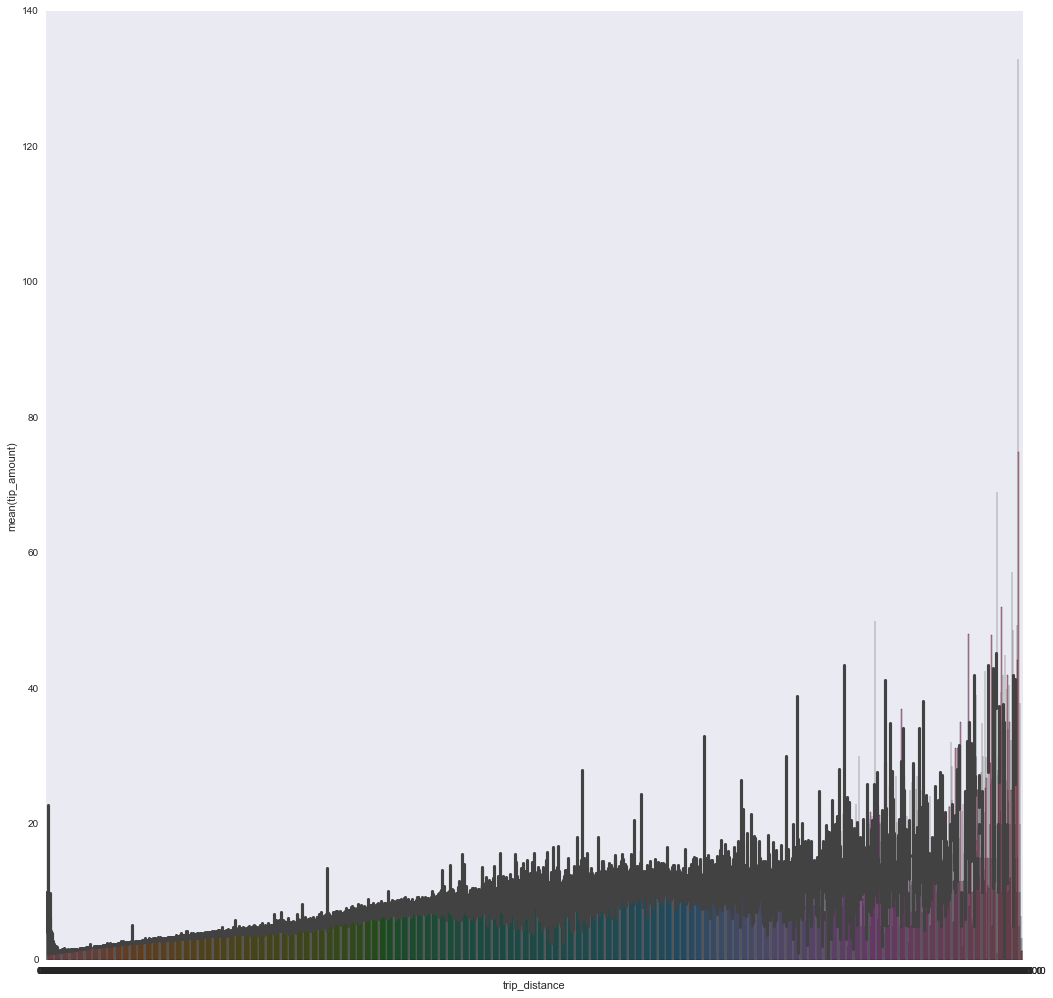

In [14]:
seaborn.barplot(x=nyc_data.trip_distance, y=nyc_data.tip_amount)

In [15]:
seaborn.barplot(x=weekday_hour_group.weekday'=='Friday', y=weekday_hour_group.tip_per_total)

SyntaxError: invalid syntax (<ipython-input-15-499d9a2da7ff>, line 1)

In [16]:
weekday_hour_group.reset_index(inplace=True)

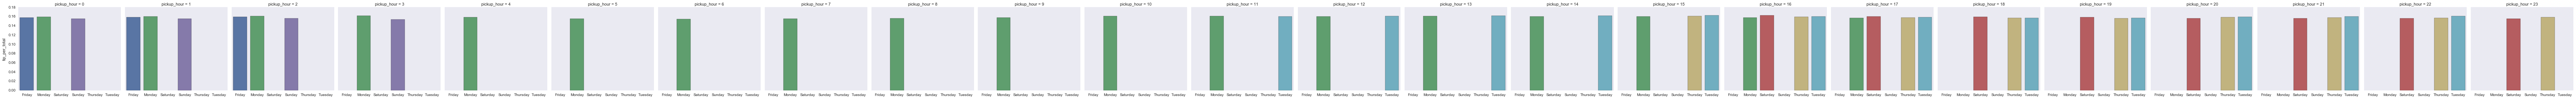

In [17]:
fg = seaborn.factorplot(x='weekday', y='tip_per_total', 
                        col='pickup_hour', data=weekday_hour_group, kind='bar')
fg.set_xlabels('')

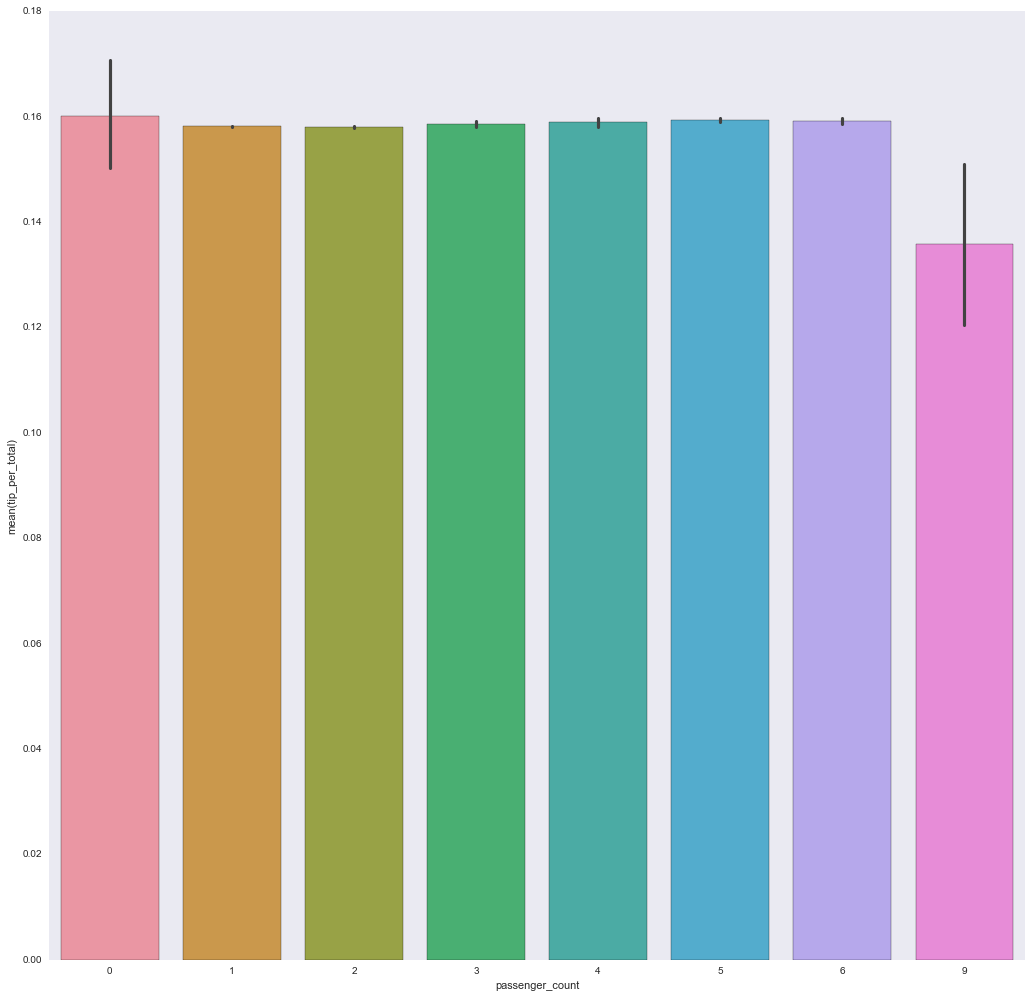

In [18]:
seaborn.barplot(x=nyc_data.passenger_count, y=nyc_data.tip_per_total)

### Read Shape File

In [25]:
shp = fiona.open('nycd_new/OGRGeoJSON.shp')
coords = shp.bounds
shp.close
print(coords)
w, h = coords[2] - coords[0], coords[3] - coords[1]
extra = 0.01

(-74.25559136315229, 40.49613398761198, -73.70000906387122, 40.91553277700521)


In [26]:
m = Basemap(
    projection='tmerc', ellps='WGS84',
    lon_0=np.mean([coords[0], coords[2]]),
    lat_0=np.mean([coords[1], coords[3]]),
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - (extra * h), 
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + (extra * h))

_out = m.readshapefile('nycd_new/OGRGeoJSON', name='nyc', drawbounds=False, color='none', zorder=2)

In [27]:
def get_town_name(lon, lat):
    point = Point(m(lon,lat))
    found = 0 
    for index, row in df_map.iterrows():
        name, polygon = row
        if polygon.contains(point):
            return name
            found = 1
            
    if not found:
        return np.NaN

#### Find Borough City Names for all rows in the Dataframe
#### This takes a lot of time

In [28]:
# set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(town_points) for town_points in m.nyc],
    'name': [town['neighborho'] for town in m.nyc_info]
})

In [ ]:
nyc_data['Neighbourhood'] = nyc_data.apply(lambda row: get_town_name(row['pickup_longitude'], row['pickup_latitude']), axis=1)

In [ ]:
nyc_data.Neighbourhood.unique()

#### Group data by Neighbour Hoods

In [ ]:
neighbourhood_group_data = nyc_data.groupby('Neighbourhood').median()

In [ ]:
neighbourhood_group_data.head()

In [ ]:
neighbourhood_group_data.reset_index(inplace=True)
agg_df = neighbourhood_group_data[['Neighbourhood', 'tip_per_total', 'tip_per_distance', 'tip_per_duration']]

#### Create Geo DF to be merged with aggregated Data Frame

In [ ]:
geo_df = pd.DataFrame(m.nyc_info)
geo_df_neighbourhoods = geo_df[['neighborho', 'borough', 'boroughCod']]

In [ ]:
agg_geo_df = pd.merge(left=geo_df_neighbourhoods, right=agg_df, how='left', left_on='neighborho', right_on='Neighbourhood')

#### Create Map for different metrics

In [ ]:
import folium

In [ ]:
nyc_geo = 'nyc_new.geojson'
map = folium.Map(location=[40.730610, -73.935242], zoom_start=6)
map.geo_json(geo_path=nyc_geo, data=agg_geo_df,
             columns=['neighborho', 'tip_per_total'],
             key_on='feature.properties.neighborhood',
             threshold_scale=[0.0, 0.156, 0.157, 0.158, 0.159],
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='NYC Tip Anaysis')
map.save('nyc_tip_per_total.html')

In [ ]:
map = folium.Map(location=[40.730610, -73.935242], zoom_start=6)
map.choropleth(geo_path=nyc_geo, data=agg_geo_df,
             columns=['neighborho', 'tip_per_distance'],
             key_on='feature.properties.neighborhood',
             threshold_scale=[0.0, 0.5, 0.1, 0.15, 0.2],
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='NYC Tip Anaysis')
map.save('nyc_tip_per_distance.html')

In [ ]:
map = folium.Map(location=[40.730610, -73.935242], zoom_start=6)
map.choropleth(geo_path=nyc_geo, data=agg_geo_df,
             columns=['neighborho', 'tip_per_duration'],
             key_on='feature.properties.neighborhood',
             threshold_scale=[0.0, 0.5, 0.1, 0.15, 0.2],
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='NYC Tip Anaysis')
map.save('nyc_tip_per_duration.html')